# Flint Michigan Data Set
[Downloadable Data Set](https://flintwaterstudy.org/2015/12/complete-dataset-lead-results-in-tap-water-for-271-flint-samples/)

You will need to move this file to your data folder,and you will need to activate your environment and install the openpyxl package in order to read the xlsx file.
```bash
conda activate Insert_Your_Environment
conda install openpyxl
```

## Upload Data to Pandas and Print Head
This allows us to see what the data consists of and validate that we have data in our dataframe

In [27]:
import pandas as pd
import os
base_data_dir = os.path.expanduser("~/data")  # Parent directory
flint_hill_xlsx_datapath = os.path.join(base_data_dir, "Flint-Samples-FINAL.xlsx")

# Specify the path to your Excel file
file_path = flint_hill_xlsx_datapath 

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Optionally, you can specify a sheet name if your Excel file has multiple sheets
# df = pd.read_excel(file_path, sheet_name='Sheet1')

# Display the first few rows of the DataFrame
df.head()

,SampleID,Zip Code,Ward,Pb Bottle 1 (ppb) - First Draw,Pb Bottle 2 (ppb) - 45 secs flushing,Pb Bottle 3 (ppb) - 2 mins flushing,Notes
0,1,48504.0,6.0,0.344,0.226,0.145,NaN
1,2,48507.0,9.0,8.133,10.77,2.761,NaN
2,4,48504.0,1.0,1.111,0.11,0.123,NaN
3,5,48507.0,8.0,8.007,7.446,3.384,NaN
4,6,48505.0,3.0,1.951,0.048,0.035,NaN


OK, are column names are pretty scattered with multiple words, lets clean them up and make them more concise and easier to work with

In [28]:
df = df.rename(columns={
    'Pb Bottle 1 (ppb) - First Draw': 'Pb_First_Draw(ppb)',
    'Pb Bottle 2 (ppb) - 45 secs flushing': 'Pb_45s_Flush(ppb)',
    'Pb Bottle 3 (ppb) - 2 mins flushing': 'Pb_2min_Flush(ppb)',
    'Zip Code' : 'Zip_Code'
})
df.head()

,SampleID,Zip_Code,Ward,Pb_First_Draw(ppb),Pb_45s_Flush(ppb),Pb_2min_Flush(ppb),Notes
0,1,48504.0,6.0,0.344,0.226,0.145,NaN
1,2,48507.0,9.0,8.133,10.77,2.761,NaN
2,4,48504.0,1.0,1.111,0.11,0.123,NaN
3,5,48507.0,8.0,8.007,7.446,3.384,NaN
4,6,48505.0,3.0,1.951,0.048,0.035,NaN



OK, this shows us samples identified by zip code and ward that were taken to understand the effect of flushing water on lead concentrations.  We note that time and exact address location is not given in this data set. In 2018 Eastern Michigan University ran [Datathon 2018](https://guides.emich.edu/datathon/data) where you can acquire additional data sets that include locations and times.  Some of these are random samples over many dates, the Sentinel Data set has set dates for resampling at the same location.  
## Initial Data Overview
We will start by printing the shape and info

In [29]:
import pandas as pd

# Load the data (assume df is already loaded)
print(df.shape)  # Rows and columns
print(df.info())  # Column names, non-null counts, data types


(289, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SampleID            286 non-null    object 
 1   Zip_Code            271 non-null    float64
 2   Ward                271 non-null    float64
 3   Pb_First_Draw(ppb)  280 non-null    float64
 4   Pb_45s_Flush(ppb)   278 non-null    object 
 5   Pb_2min_Flush(ppb)  271 non-null    float64
 6   Notes               4 non-null      object 
dtypes: float64(4), object(3)
memory usage: 15.9+ KB
None


### Initial Inspection
We note several interesting things
1. We have 289  data entries indexed from 0 to 288
2. **Pb Bottles 1 and 3 are floats, while Bottles 2 is an object**, probably a string. A look at the .head() tells us something went wrong as they should all be floats.
3. There are notes for four items.

So we will first take a look at the notes in case it tells us something about those data samples that makes the data invalid, and then proceed to tackle the issue of the non-float data type for sample 2

To find the non null notes we can use the following script
```python
# Filter rows where 'Notes' is NOT null
notes_df = df[df['Notes'].notnull()]

# Display those rows
print(notes_df)
```

In [30]:
# Filter rows where 'Notes' is NOT null
notes_df = df[df['Notes'].notnull()]

# Display those rows
notes_df

,SampleID,Zip_Code,Ward,Pb_First_Draw(ppb),Pb_45s_Flush(ppb),Pb_2min_Flush(ppb),Notes
26,31,48503.0,7.0,6.087,28.87,2.130,*house sampled twice
27,31,48503.0,7.0,10.320,13.47,18.190,*house sampled twice
69,79,48503.0,6.0,6.300,1.1,0.300,*house sampled twice
70,79,48503.0,6.0,5.153,0.385,0.322,*house sampled twice


OK, what we see is that sample IDs 31 and 79 were taken twice, and sample 31 is interesting in that the levels went from 6 to 28 to 2, which indicates something happened.  It could be faulty measurements, or maybe there was some lead ions that entered into the water as a result of flushing. It would have been nicer if the notes were more detailed.
### Tackle non Float Data
Pandas tackles non-numeric entites like "not detected", n/a... as objects, and only converts NaNs as floats.
So let's see what is in that column
```python
df['Pb_45s_Flush'].unique()
```

In [31]:
df['Pb_45s_Flush(ppb)'].unique()

array([0.226, 10.77, 0.11, 7.446, 0.048, 1.4, 9.726, 2.5, 1.038, 4.2,
       0.822, 8.796, 5.752, 1.099, 0.72, 1.046, 0.243, 0.622, 0.674,
       239.7, 0.406, 10.26, 1.13, 2.474, 8.4, 0.223, 28.87, 13.47, 2.662,
       3.543, 80.47, 3.406, 0.21, 3.679, 0.3, 0.142, 2.534, 4.132, 0.156,
       0.373, 5.157, 0.441, 1.395, 2.682, 0.8, 1.332, 2.852, 0.467, 0.494,
       1.808, 0.393, 42.58, 3.649, 1.76, 0.5, 0.166, 5.206, 1.948, 12.84,
       0.355, 6.694, 3.86, 0.288, 0.292, 0.729, 9.645, 7.744, 0.555,
       1.192, 1.1, 0.385, 0.927, 4.73, 9.894, 3.734, 2.17, 2.989, 2.315,
       5.141, 0.983, 0.758, 11.65, 2.745, 0.2, 1051, 0.363, 0.59, 4.444,
       4.883, 5.882, 8.578, 0.291, 2.301, 11.13, 0.953, 5.894, 0.455,
       3.978, 5.592, 2.202, 0.183, 2.984, 0.19, 2.9, 0.13, 1.388, 0.284,
       0.568, 3.7, 1.405, 2.767, 0.736, 0.306, 1.724, 5.672, 2.808, 1.265,
       4.196, 7.688, 1.409, 17.75, 0.032, 1.355, 2.001, 1.211, 0.374,
       0.902, 0.253, 0.438, 1.881, 7.553, 3.341, 1.316, 1.594

OK,we see the problem, Pandas 'ppb' is a string and Pandas converted everything to objects. These appears to be a rogue data point where the experiment uploaded invalid data, but lets check. We can print the line with:
```python
df[df['Pb_45s_Flush'] == 'ppb']
print(df)
```

In [32]:
df[df['Pb_45s_Flush(ppb)'] == 'ppb']

,SampleID,Zip_Code,Ward,Pb_First_Draw(ppb),Pb_45s_Flush(ppb),Pb_2min_Flush(ppb),Notes
271,Average (First Draw),NaN,NaN,10.645993,ppb,NaN,NaN
272,90th Percentile (First Draw),NaN,NaN,26.792000,ppb,NaN,NaN
273,Maximum (First Draw),NaN,NaN,158.000000,ppb,NaN,NaN
274,Maximum (Any sample),NaN,NaN,1051.000000,ppb,NaN,NaN
281,Sample #244 (in ascending order; not ID),NaN,NaN,26.640000,ppb,NaN,NaN
282,Sample #245 (in ascending order; not ID),NaN,NaN,27.020000,ppb,NaN,NaN
283,90th Percentile Calculation,NaN,NaN,26.792000,ppb,NaN,NaN


OK, we see that these 'ppb's occur near the tail of the dataframe, and appear to be some sort of analysis and not actual data and the earliest index is 271, lets print the last twenty records of the dataframe

In [33]:
df.tail(20)

,SampleID,Zip_Code,Ward,Pb_First_Draw(ppb),Pb_45s_Flush(ppb),Pb_2min_Flush(ppb),Notes
269,299,48503.0,7.0,29.590000,3.258,1.843,NaN
270,300,48505.0,1.0,4.287000,4.345,4.905,NaN
271,Average (First Draw),NaN,NaN,10.645993,ppb,NaN,NaN
272,90th Percentile (First Draw),NaN,NaN,26.792000,ppb,NaN,NaN
273,Maximum (First Draw),NaN,NaN,158.000000,ppb,NaN,NaN
274,Maximum (Any sample),NaN,NaN,1051.000000,ppb,NaN,NaN
275,Total No. of Samples,NaN,NaN,271.000000,NaN,NaN,NaN
276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277,IMPORTANT: Please note that the detection limi...,NaN,NaN,NaN,NaN,NaN,NaN
278,NaN,NaN,NaN,NaN,NaN,NaN,NaN


OK, we see the problem; and learned a lesson.  The tail of the dataframe is metadata and analysis, not data. So we should always look at both the head() and tail() of a data set, as sometimes the tail has non-data elements to it.  Now you should extend the tail to 30 records to see if the data is really following a logical progression in sample numbers. So before proceeding we will clean this up.  We want to do two things, capture the metadata in a different dataframe just to compare it to our analysis, and create a clean dataframe with just data in it.
### Cleaning the DataFrame
There are several approaches
- **Integer Index Slicing**
Keep Rows where 'Sample ID' is only a number, and this will exclude them if the ID is NaN, even though that is technically a float (don't you love Pandas!)
```python
# Keep only rows where SampleID is a number (<=300)
df_clean = df.loc[df['SampleID'].apply(lambda x: str(x).isdigit())].copy()
```
The disadvantage of this is if any of the Sample IDs are floats, it will exclude them too
- **Explicit Row Cutoff**
df_clean = df.loc[df.index <= 270].copy()
```
The disadvantage of this approach is that it will miss any mistakes inside of the data (before the tail), but since we already identified that the only unique string is 'ppb' and the ealiest one is in row 271, we can feel somewhat confident that this will not be a problem.  So we will make a new DataFrame called df_clean with the first 270 rows

In [34]:
df_clean = df.loc[df.index <= 270].copy()
df_clean.tail()

,SampleID,Zip_Code,Ward,Pb_First_Draw(ppb),Pb_45s_Flush(ppb),Pb_2min_Flush(ppb),Notes
266,295,48503.0,7.0,18.110,20.21,4.263,NaN
267,296,48503.0,7.0,12.810,7.874,1.780,NaN
268,298,48503.0,7.0,1.083,0.322,0.260,NaN
269,299,48503.0,7.0,29.590,3.258,1.843,NaN
270,300,48505.0,1.0,4.287,4.345,4.905,NaN


Now, if we want a dataframe with the metadata, we can do a similar explicit cut off, but cut off the beginning, not the end

In [35]:
# Get rows after the sample data
df_metadata = df.loc[df.index > 270].copy()
df_metadata

,SampleID,Zip_Code,Ward,Pb_First_Draw(ppb),Pb_45s_Flush(ppb),Pb_2min_Flush(ppb),Notes
271,Average (First Draw),NaN,NaN,10.645993,ppb,NaN,NaN
272,90th Percentile (First Draw),NaN,NaN,26.792000,ppb,NaN,NaN
273,Maximum (First Draw),NaN,NaN,158.000000,ppb,NaN,NaN
274,Maximum (Any sample),NaN,NaN,1051.000000,ppb,NaN,NaN
275,Total No. of Samples,NaN,NaN,271.000000,NaN,NaN,NaN
276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277,IMPORTANT: Please note that the detection limi...,NaN,NaN,NaN,NaN,NaN,NaN
278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,90th Percentile Calculation,NaN,NaN,NaN,NaN,NaN,NaN
280,Sample to be considered for 90th percentile,NaN,NaN,244.400000,NaN,NaN,NaN


Let's now check the clean dataframe

In [36]:
print(df_clean.shape)
df_clean.info()

(271, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 271 entries, 0 to 270
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SampleID            271 non-null    object 
 1   Zip_Code            271 non-null    float64
 2   Ward                271 non-null    float64
 3   Pb_First_Draw(ppb)  271 non-null    float64
 4   Pb_45s_Flush(ppb)   271 non-null    object 
 5   Pb_2min_Flush(ppb)  271 non-null    float64
 6   Notes               4 non-null      object 
dtypes: float64(4), object(3)
memory usage: 16.9+ KB


OK, now that we have cleaned the data we need to tackle the Data type.  There are three conversions we need to make:
1. Pb_45s_flush(ppb) from object to float64
2. Zipcode from float64 to string (as it is really a category and not a number)
3. Sample ID from object to Int 64 - Because Int 64 can handle NaN while regular int can not.
4. Ward from float64 to int 64

```python
# Convert Pb_45s_Flush(ppb) to float
df_clean['Pb_45s_Flush(ppb)'] = pd.to_numeric(df_clean['Pb_45s_Flush(ppb)'], errors='coerce')

# Convert SampleID to integer
df_clean['SampleID'] = pd.to_numeric(df_clean['SampleID'], errors='coerce').astype('Int64')

# Convert Zip Code to string
df_clean['Zip_Code'] = pd.to_numeric(df_clean['Zip_Code'], errors='coerce').astype('Str')

# Convert Ward to integer
df_clean['Ward'] = pd.to_numeric(df_clean['Ward'], errors='coerce').astype('Int64')
```


In [37]:
# Convert Pb_45s_Flush(ppb) to float
df_clean['Pb_45s_Flush(ppb)'] = pd.to_numeric(df_clean['Pb_45s_Flush(ppb)'], errors='coerce')

# Convert SampleID to integer
df_clean['SampleID'] = pd.to_numeric(df_clean['SampleID'], errors='coerce').astype('Int64')

# Convert Zip_Code to string, .str.zfill(r) converts adds leading zeros so there are 5 digits
df_clean['Zip Code'] = pd.to_numeric(df_clean['Zip_Code'], errors='coerce').astype('Int64').astype(str).str.zfill(5)

# Convert Ward to integer
df_clean['Ward'] = pd.to_numeric(df_clean['Ward'], errors='coerce').astype('Int64')
print(df_clean.shape)
print(df_clean.info())
print(df_clean.head())
df_clean.tail()

(271, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 271 entries, 0 to 270
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SampleID            271 non-null    Int64  
 1   Zip_Code            271 non-null    float64
 2   Ward                271 non-null    Int64  
 3   Pb_First_Draw(ppb)  271 non-null    float64
 4   Pb_45s_Flush(ppb)   271 non-null    float64
 5   Pb_2min_Flush(ppb)  271 non-null    float64
 6   Notes               4 non-null      object 
 7   Zip Code            271 non-null    object 
dtypes: Int64(2), float64(4), object(2)
memory usage: 19.6+ KB
None
   SampleID  Zip_Code  Ward  Pb_First_Draw(ppb)  Pb_45s_Flush(ppb)  \
0         1   48504.0     6               0.344              0.226   
1         2   48507.0     9               8.133             10.770   
2         4   48504.0     1               1.111              0.110   
3         5   48507.0     8               8.007       

,SampleID,Zip_Code,Ward,Pb_First_Draw(ppb),Pb_45s_Flush(ppb),Pb_2min_Flush(ppb),Notes,Zip Code
266,295,48503.0,7,18.110,20.210,4.263,NaN,48503
267,296,48503.0,7,12.810,7.874,1.780,NaN,48503
268,298,48503.0,7,1.083,0.322,0.260,NaN,48503
269,299,48503.0,7,29.590,3.258,1.843,NaN,48503
270,300,48505.0,1,4.287,4.345,4.905,NaN,48505


## Finding Missing Sample IDs
Note in the head sample ID 3 is missing, and that the last sample ID is 300, but there are only 271 records.  This means we are missing 29 records.  Lets find the missing sample IDs:

In [38]:
expected_ids = set(range(1, 301))
actual_ids = set(df_clean['SampleID'].dropna().astype(int))
missing_ids = sorted(expected_ids - actual_ids)
print(missing_ids)

[3, 10, 11, 14, 32, 60, 61, 62, 64, 70, 81, 86, 89, 94, 120, 157, 160, 175, 181, 187, 188, 190, 199, 232, 233, 239, 257, 261, 277, 288, 297]


We noted from the notes that there were two houses that were measured twice, and that the sample IDs 31 and 79 were duplicated

In [39]:
# Find all rows where SampleID is duplicated (any occurrence)
duplicates_df = df_clean[df_clean['SampleID'].duplicated(keep=False)]

duplicates_df

,SampleID,Zip_Code,Ward,Pb_First_Draw(ppb),Pb_45s_Flush(ppb),Pb_2min_Flush(ppb),Notes,Zip Code
26,31,48503.0,7,6.087,28.870,2.130,*house sampled twice,48503
27,31,48503.0,7,10.320,13.470,18.190,*house sampled twice,48503
69,79,48503.0,6,6.300,1.100,0.300,*house sampled twice,48503
70,79,48503.0,6,5.153,0.385,0.322,*house sampled twice,48503


## Trends
expected trend sample 1 > sample 2 > sample 3

Look at index 26 and 27, they represent different trends.  So lets try and identify the trends.

In [40]:
def classify_trend(row):
    v1 = row['Pb_First_Draw(ppb)']
    v2 = row['Pb_45s_Flush(ppb)']
    v3 = row['Pb_2min_Flush(ppb)']
    
    if pd.isnull(v1) or pd.isnull(v2) or pd.isnull(v3):
        return 'Incomplete Data'
    
    if v1 > v2 > v3:
        return 'Expected'
    elif v1 < v2 > v3 and v1 < v3:
        return 'Trend 1 Unexpected'
    elif v1 < v2 > v3 and v1 > v3:
        return 'Trend 2 Unexpected'        
    elif v1 < v2 < v3:
        return 'Trend 3 Unexpected'
    elif v1 > v2 < v3:
        return 'Trend 4 Unexpected'
    else:
        return 'Other'

df_clean['Trend'] = df_clean.apply(classify_trend, axis=1)
trend_counts = df_clean['Trend'].value_counts()
print(trend_counts)
print(df_clean.head())


Trend
Expected              178
Trend 4 Unexpected     39
Trend 2 Unexpected     34
Trend 3 Unexpected      9
Trend 1 Unexpected      6
Other                   5
Name: count, dtype: int64
   SampleID  Zip_Code  Ward  Pb_First_Draw(ppb)  Pb_45s_Flush(ppb)  \
0         1   48504.0     6               0.344              0.226   
1         2   48507.0     9               8.133             10.770   
2         4   48504.0     1               1.111              0.110   
3         5   48507.0     8               8.007              7.446   
4         6   48505.0     3               1.951              0.048   

   Pb_2min_Flush(ppb) Notes Zip Code               Trend  
0               0.145   NaN    48504            Expected  
1               2.761   NaN    48507  Trend 2 Unexpected  
2               0.123   NaN    48504  Trend 4 Unexpected  
3               3.384   NaN    48507            Expected  
4               0.035   NaN    48505            Expected  


In [41]:
df_long = pd.melt(
    df_clean,
    id_vars=['SampleID', 'Trend'],  # These stay the same
    value_vars=['Pb_First_Draw(ppb)', 'Pb_45s_Flush(ppb)', 'Pb_2min_Flush(ppb)'],  # These become one column
    var_name='Sample_Type',  # New column holding the name of the original column
    value_name='Lead_ppb'    # New column holding the actual value
)
df_long.head()

,SampleID,Trend,Sample_Type,Lead_ppb
0,1,Expected,Pb_First_Draw(ppb),0.344
1,2,Trend 2 Unexpected,Pb_First_Draw(ppb),8.133
2,4,Trend 4 Unexpected,Pb_First_Draw(ppb),1.111
3,5,Expected,Pb_First_Draw(ppb),8.007
4,6,Expected,Pb_First_Draw(ppb),1.951


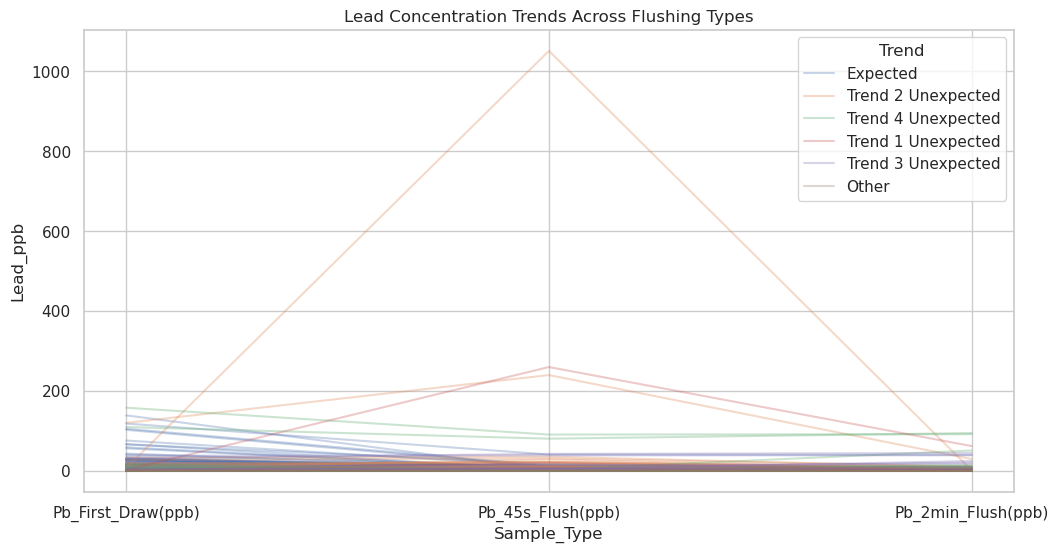

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_long,
    x='Sample_Type',
    y='Lead_ppb',
    hue='Trend',
    estimator=None,  # plot each line individually
    units='SampleID',  # lines per sample
    alpha=0.3
)
plt.title('Lead Concentration Trends Across Flushing Types')
plt.show()


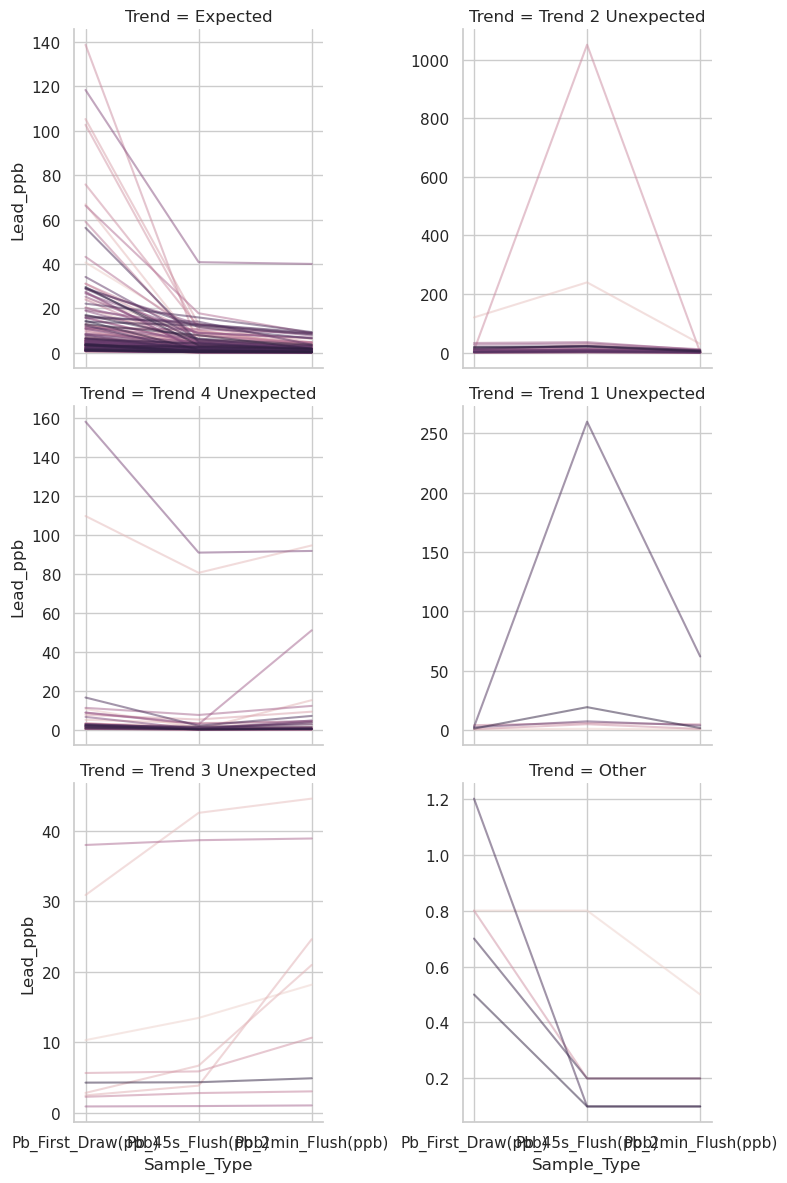

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the FacetGrid with 3 rows, 2 columns
g = sns.FacetGrid(df_long, col="Trend", col_wrap=2, height=4, sharey=False)

# Plot each sample line, grouped by SampleID
g.map_dataframe(
    sns.lineplot,
    x="Sample_Type",
    y="Lead_ppb",
    hue="SampleID",  # We'll suppress the legend, so this is safe
    estimator=None,
    alpha=0.5,
    legend=False  # <<< Disable legend to avoid clutter
)

# Remove subplot legends if any appeared
for ax in g.axes.flat:
    legend = ax.get_legend()
    if legend:
        legend.remove()

# Display the grid
plt.show()



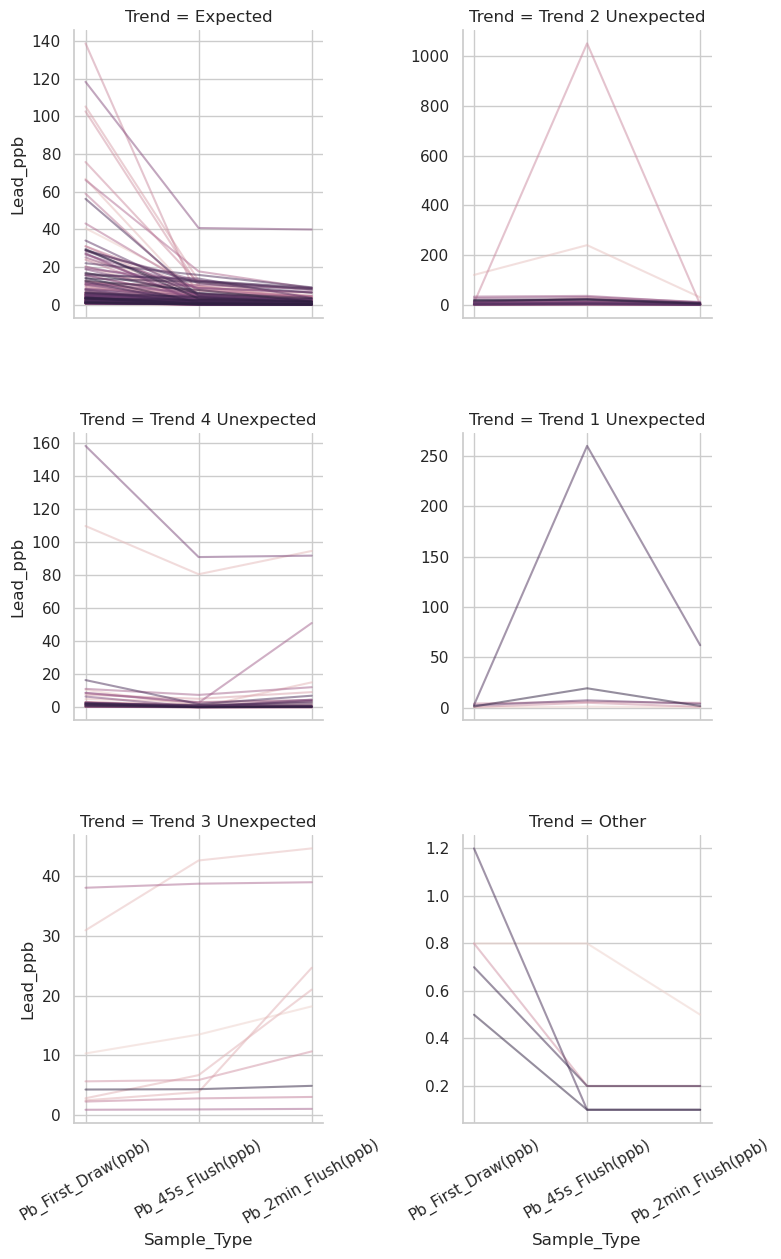

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the FacetGrid
g = sns.FacetGrid(df_long, col="Trend", col_wrap=2, height=4, sharey=False)

# Plot without legend
g.map_dataframe(
    sns.lineplot,
    x="Sample_Type",
    y="Lead_ppb",
    hue="SampleID",
    estimator=None,
    alpha=0.5,
    legend=False
)

# Rotate x-axis tick labels for readability
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=30)  # Rotate labels 30 degrees
    legend = ax.get_legend()
    if legend:
        legend.remove()

# Adjust spacing between titles and tick labels
plt.subplots_adjust(hspace=0.4)  # Increase vertical spacing

plt.show()


## Unique Zip Codes and Wards
Our next goal is to find the unique zip codes and wards

In [ ]:
print(f"Number of unique zip  codes and wards: {df['Zip Code'].nunique(), df['Ward'].nunique()}.\n")
      
print(f"Unique zip  codes and wards: {df['Zip Code'].unique(), df['Ward'].unique()}.")
print(df['Zip Code'].value_counts())
print(df['Ward'].value_counts())


## Clean and rename columns

## Summary Stats of Lead Levels

In [ ]:
df['Pb_First_Draw'].describe()


## Box Plot by Ward

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Ward', y='Pb_First_Draw', data=df)
plt.title('Lead Concentration (First Draw) by Ward')
plt.show()


## Box Plot by Sip Code

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Zip Code', y='Pb_First_Draw', data=df)
plt.title('Lead Concentration (First Draw) by Zip Code')
plt.xticks(rotation=45)
plt.show()


Characterization of the Configuration Vector in Air Sensor Pods

Configuration Vector Characterization in Low Cost Air Sensor Pods